#Análisis Factorial Exploratorio (AFE) de variables continuas con Python:
El Análisis Factorial Exploratorio (AFE) es un método para reducir la dimensionalidad de un conjunto de variables/indicadores, es decir, es un método para resumir la información. En este sentido, puede confundirse con el Análisis de Componentes Principales (ACP).

El ACP parte de la varianza total para encontrar combinaciones lineales entre las variables originales que expliquen la mayor parte de dicha varianza total. Así, el primer componente principal sería aquella combinación lineal de variables que explica un mayor porcentaje de varianza total; el segundo componente principal sería aquel que explica la mayor proporción de varianza no explicada por el primero, y así sucesivamente.Al aplicar ACP a un conjunto de datos conseguimos pues resumir la información en unas pocas componentes principales. Dichas componentes principales, al ser combinaciones lineales de variables, resultan, muchas veces, difíciles de interpretar.

Por su parte, el AFE distingue entre varianza común y varianza específica. La varianza común o compartida es aquella parte de la variabilidad total de los datos que está compartida entre las variables; mientras, la varianza no compartida es la específica de cada variable. Los factores comunes son, por tanto, variables subyacentes - no observadas - que explican la asociación entre las variables.

Asimismo, desde el punto de vista de las variables, decimos que la comunalidad de una variable es la parte de su varianza explicada por los factores comunes. Por ello, interesa que este dato sea alto. Por el contrario, la especificidad es la parte de variabilidad de una variable específica de dicha variable. Esta última conviene pues que sea baja.

Los factores sí suelen tener una interpretación más sencilla que los componentes principales. Asimismo, mientras los componentes principales, por definición, no están correlacionados, los factores pueden estarlo.

El AFE suele utilizarse con datos procendentes de encuestas sociales, psicológicas o sanitarias, sin embargo, también puede aplicarse a otros tipos de datos, como los que utilizamos en este caso.


##Librerías:

In [ ]:
import pandas as pd #Para el manejo de dataframes
import numpy as np #Para trabajar con arrays y para realizar operaciones matemáticas y estadísticas básicas

!pip install pingouin
#Esta libreria, a veces, da problemas al instalarla a la primera. Para solucionar el problema: debemos darla al botón "Rerun Runtime", que aparece; esperar a que se inicie de nuevo el cuaderno, y volver a correr esta parte del script.
from pingouin import multivariate_normality #Para realizar el test de Henze-Zirkler (H-Z) de normalidad multivariante

import seaborn as sns #Para graficar la matriz de correlaciones
import matplotlib.pyplot as plt #Para realizar el gráfico de sedimentación

!pip install factor_analyzer
import factor_analyzer #Para realizar el Análisis Factorial Exploratorio (AFE)

## Datos:
Vamos a simular unos datos con supuesta información de 1000 jugadores de fútbol. Estos datos contienen información sobre su altura, peso, ganancias y edad.

Los vamos a simular de tal forma que las variables Altura y Peso estén fuertemente correlacionadas y lo mismo para las variables Ganancias y Partidos. Debido a ello, la estructura factorial teórica presenta dos factores: Altura-Peso y Ganancias-Partidos.

In [ ]:
np.random.seed(1000) #Establecemos una semilla para facilitar la reproductibilidad de los resultados

cov_Altura_Peso = 0.7*np.sqrt((20**2)*(15**2)) #La covarianza entre X e Y es igual al producto de su correlación por sus desviaciones típicas
cov_Ganancias_Partidos = 0.8*np.sqrt((50000**2)*(150**2))

cov_matriz = [[          20**2, cov_Altura_Peso,                      0,                      0],
              [cov_Altura_Peso,           15**2,                      0,                      0],
              [              0,               0,               50000**2, cov_Ganancias_Partidos],
              [              0,               0, cov_Ganancias_Partidos,                 150**2]]

mu = [170, 75, 250000, 400]    

datos_correlados = np.random.multivariate_normal(mu, cov_matriz, size=1000)

datos_AFE = pd.DataFrame(
    {
     "Altura":    abs(datos_correlados[:, 0]), #La altura sigue una normal N(170, 20)
     "Peso":      abs(datos_correlados[:, 1]), #El peso sigue una normal N(75, 15)
     "Ganancias": abs(datos_correlados[:, 2]), #Las ganancias siguen una normal N(250000, 50000)
     "Partidos":  abs(datos_correlados[:, 3])  #Los partidos sigue una normal N(400, 150)
     }
    )
datos_AFE.head()

,Altura,Peso,Ganancias,Partidos
0,167.197588,80.271164,290222.845855,525.418982
1,174.531984,72.702864,265039.749513,471.148226
2,161.220590,60.214885,220248.325264,286.775672
3,172.998547,78.142462,309803.579378,506.992641
4,150.456017,51.037011,256920.947000,480.122640


### Paso 1: Estimación de la matriz de correlaciones.
Dependiendo del tipo de datos que tengamos, debemos utilizar un tipo de correlación u otro:
* Datos continuos: La matriz de correlaciones de Pearson y la de Spearman son las más apropiadas ante continuos o ante datos ordinales (categóricos) con más de 7 categorías de respuesta (tienden a la continuidad).
* Datos categóricos/ordinales: la matriz de correlaciones policórica es la más recomendada ante datos ordinales de 7 o menos categorías de respuesta. Si tuviéramos datos dicotómicos, la matriz a emplear sería la matriz tetracórica (similar a la policórica pero con datos dicotómicos).

En nuestro caso, como tenemos datos continuos, usaremos la matriz de correlaciones de Pearson.

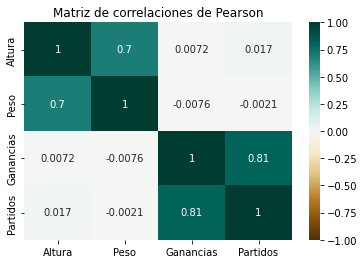

In [ ]:
matriz_correlaciones = datos_AFE.corr();
heatmap = sns.heatmap(matriz_correlaciones, vmin=-1, vmax=1, annot=True, cmap='BrBG');
heatmap.set_title("Matriz de correlaciones de Pearson");

Como esperábamos, vemos que Altura y Peso están bastante correlacionadas (r=0,7), y lo mismo ocurre con Ganancias y Partidos (r=0,1)

### Paso 2: Verificar que la matriz sea factorizable (es decir, que tiene sentido hacer un AFE con nuestros datos):
(Si la matriz no fuese factorizable, la relación entre las variables sería tan baja que no se formarían factores).

Entre los métodos para comprobar si la matriz es factorizable destacan:
* Test de esfericidad de Bartlett: se pregunta si la matriz de correlaciones es o no la matriz identidad. Si la matriz de correlaciones es la matriz identidad, las variables no estarían correlacionadas y no habría varianza compartida de la que extraer los factores (no habría factores comunes). Si rechazamos la hipótesis nula (la matriz de correlaciones es la matriz identidad), la matriz será factorizable.
* Medida KMO (Kaiser-Meyer-Olkin): expresa el grado de predicción de las variables a partir de las demás. Su valor oscila entre 0 y 1. Cuanto mayor sea, mejor. Valores a partir de 0,5 se consideran aceptables.
* Calcular el determinante de la matriz de correlaciones: valores cercanos a cero indican que la matriz es factorizable.

In [ ]:
print("El resultado del test de esfericidad de Bartlett es:")
factor_analyzer.factor_analyzer.calculate_bartlett_sphericity(datos_AFE)

El resultado del test de esfericidad de Bartlett es:


(1728.5504659326211, 0.0)

In [ ]:
print("La medida KMO es:")
factor_analyzer.factor_analyzer.calculate_kmo(datos_AFE)

La medida KMO es:


(array([0.49938309, 0.49940885, 0.4995582 , 0.49946286]), 0.49946121357683904)

In [ ]:
print("El determinante de la matriz es:")
np.linalg.det(matriz_correlaciones)

El determinante de la matriz es:


0.17727739029788253

1. El p-valor es menor a los niveles de significación habituales(10%, 5% y 1%) por lo que rechazamos la hipótesis nula: la matriz de correlaciones no es la matriz identidad.
2. El resultado del KMO es de, aproximadamente, 0,5.
3. El determinante tiene un valor no excesivamente bajo: 0,17727739029788253
En general, los test no arrojan resultados óptimos, pero continuamos adelante con el AFE.



### Paso 3: determinar un método de extracción de factores:
La ecuación del modelo factorial es la siguiente:

\begin{align}
X_j = a_{j1}F_1 + a_{j2}F_2
+ ... +a_{jn}F_n + u_j
\end{align}

Donde $X_j$ (variable j) es una combinación lineal de factores comunes y del factor único (especificidad). Los $a_{jh}$ son los pesos factoriales, que representan la importancia que cada factor común tiene en explicar la variable $X_j$.

El objetivo de los métodos de extracción de factores es reproducir, con el mínimo error, la matriz de correlaciones a partir de la matriz de pesos factoriales.

Existen varios métodos de extracción de factores. Los más comunes son:
*   Máxima Verosimilitud (*Maximum Likelihood*, ML). Para utilizarlo, nuestros datos deben seguir una normal multivariante (lo que podemos comprobar realizando el test de Mardia o el de Henze-Zirkler, por ejemplo). Estadísticamente es el más adecuado, pues es asintóticamente insesgado, eficiente y consistente.
*   Mínimos Cuadrados No Ponderados (*Unweighted Least Squares*, ULS) (También llamado Residuos Mínimos, MinRes). No requiere de la existencia de normalidad multivariante.
* Ejes principales. Tampoco requiere de datos que sigan una normal multivariante.
* Componentes principales. Como hemos dicho en la introducción, no es método de ánalisis factorial propiamente dicho, ya que su objetivo es intentar explicar toda la varianza, y no solo la varianza común o compartida. Sin embargo, su uso, aunque no se recomiende, está bastante extendido, pues es la opción por defecto de muchos programas estadísticos.

En principio, nuestros datos deben seguir una normal multivariante ya que así los hemos simulado, por lo que podríamos emplear el método ML. De todas formas, vamos a realizar el test de Henze-Zirkler para comprobarlo.




In [ ]:
#Test Henze-Zirkler de normalidad multivariante:
multivariate_normality(datos_AFE, alpha=.05)

HZResults(hz=0.8927771905803024, pval=0.6197270087811485, normal=True)

Como los p-valores son superiores a los niveles de significación habituales (10%, 5% y 1%) no se rechaza la hipótesis nula del test de Henze-Zirkler, es decir, no se rechaza la normalidad multivariante de los datos. Por tanto, podemos usar Máxima Verosimilitud.

### Paso 4: Determinamos el número de factores a extraer:
Existen cuatro métodos principales:
* Regla de Kaiser: se deben aceptar todos aquellos factores con un autovalor mayor a 1.
* Gráfico de sedimentación (*scree plot*): gráfico donde podemos ver cómo disminuye la varianza explicada o el autovalor a medida que vamos aumentando el número de factores a extraer. Se complementa muy bien con la regla de Kaiser. 
* Establecimiento de un porcentaje de varianza explicada mínimo (por ejemplo, el 75%): cogeríamos todos los factores necesarios para explicar ese porcentaje mínimo de varianza.
* Análisis paralelo (AP, método recomendado): el AP parte de generar nuevas muestras aleatorias (mínimo 100) con el mismo número de variables y observaciones que la muestra original y, a partir de ello, se queda con aquellos factores cuyo autovalor es superior a los generados por azar. 

En Python no existe a día de hoy una librería para llevar a cabo el análisis paralelo de forma sencilla. Por ello, usaremos otros métodos como la regla de Kaiser y el gráfico de sedimentación. No obstante, en el siguiente link puede encontrarse una función que implementa el análisis paralelo en Python:
https://stackoverflow.com/questions/62303782/is-there-a-way-to-conduct-a-parallel-analysis-in-python

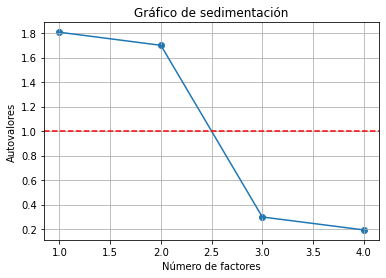

In [ ]:
#Primero realizamos un análisis factorial exploratorio sin rotación
fa = factor_analyzer.FactorAnalyzer(rotation=None)
fa.fit(datos_AFE)
#Obtenemos los autovalores:
#Nos provee de dos tipos de autovalores (los originales y los de los factores comunes. Nos quedamos con los primeros)
autovalores, autovalores_FactoresComunes = fa.get_eigenvalues()
#Creamos el gráfico de sedimentación:
plt.scatter(range(1,datos_AFE.shape[1]+1), autovalores)
plt.plot(range(1,datos_AFE.shape[1]+1), autovalores)
plt.axhline(y=1, color='r', linestyle='--') #Para mostrar la línea de autovalor = 1
plt.title("Gráfico de sedimentación")
plt.xlabel("Número de factores")
plt.ylabel("Autovalores")
plt.grid() #Para insertar una rejilla en el gráfico

Como vemos, tanto la regla de Kaiser como el gráfico de sedimentación nos indican que debemos extraer dos factores.

### Extracción de factores:
Vamos a extraer dos factores, siguiendo la regla de Kaiser.

Asimismo, debemos decidir si vamos a rotar los factores y qué tipo de rotación vamos a emplear. Los métodos de rotación facilitan la interpretación de los factores, ya que sin rotarlos, suele ser muy difíciles de interpretar, por lo que se recomienda el uso de dichas técnicas de rotación.

Existen dos tipos de rotación:
* Rotación oblicua: permite que los factores puedan tener correlación entre ellos. Tipo recomendado, ya que es el más cercano a la estructura real que deseamos explorar. Un ejemplo es el método *oblimin*.
* Rotación ortogonal: fuerza a los factores a que no puedan tener correlación entre ellos. Un ejemplo es el método *varimax*.

Probaremos los dos y nos quedaremos con la solución que mejor resultado arroje. Pero, ¿cómo determinamos qué solución factorial ajusta mejor?
* Fijándonos en los pesos factoriales: Cuanto mayor sea el peso factorial de un ítem en un factor mejor. Se aceptan pesos factoriales por encima de 0,4. En general, una buena solución presentará variables que pesan mucho en un factor y poco en el resto.
* Índices de bondad del ajuste. Existen unos cuantos, pero nos podemos fijar en RMSEA, SRMR, TLI y CFI. RMSEA y SRMR cuantos más bajos mejor (se aceptan valores por debajo de 0,08), y TLI y CFI cuantos más altos mejor (valores por encima de 0,95 se consideran muy buenos). Desgraciadamente, esta librería de Python, no cuenta con funciones para estimar dichos índices de ajuste.

In [ ]:
#Con rotación oblicua oblimin:
fa_oblimin = factor_analyzer.FactorAnalyzer(rotation="oblimin", method='ml', n_factors=2);
fa_oblimin.fit(datos_AFE);
pd.DataFrame(fa_oblimin.loadings_, columns=["Factor1", "Factor2"], index=[datos_AFE.columns])

,Factor1,Factor2
Altura,0.007374,0.891587
Peso,-0.010715,0.786595
Ganancias,0.812440,-0.005160
Partidos,0.993128,0.002827


In [ ]:
pd.DataFrame(fa_oblimin.get_factor_variance(), columns=["Factor1", "Factor2"], index=["Varianza de cada factor", "Proporción de varianza explicada", "Varianza acumulada"])

,Factor1,Factor2
Varianza de cada factor,1.646532,1.413693
Proporción de varianza explicada,0.411633,0.353423
Varianza acumulada,0.411633,0.765056


1.   Vemos que los items que más pesan en el factor 1 son los correspondientes a las variables Ganancias y Partidos.
2.   Los items que más pesan en el factor 2 son los correspondientes a las variables Altura y Peso.

Los pesos factoriales son muy buenos, ya que, para cada variable, son muy altos en un solo factor, y bajos en el otro.

In [ ]:
#Con rotación ortogonal varimax:
fa_varimax = factor_analyzer.FactorAnalyzer(rotation="varimax", method='ml', n_factors=2);
fa_varimax.fit(datos_AFE);
pd.DataFrame(fa_varimax.loadings_, columns=["Factor1", "Factor2"], index=[datos_AFE.columns])
#De nuevo, vemos que los items que más pesan en el factor 1 son los correspondientes a las variables Ganancias y Partidos
#Los items que más pesan en el factor 2 son los correspondientes a las variables Altura y Peso

,Factor1,Factor2
Altura,0.017795,0.891499
Peso,-0.001521,0.786580
Ganancias,0.812374,-0.008084
Partidos,0.993155,-0.000747


In [ ]:
pd.DataFrame(fa_varimax.get_factor_variance(), columns=["Factor1", "Factor2"], index=["Varianza de cada factor", "Proporción de varianza explicada", "Varianza acumulada"])

,Factor1,Factor2
Varianza de cada factor,1.646628,1.413544
Proporción de varianza explicada,0.411657,0.353386
Varianza acumulada,0.411657,0.765043


Los resultados son casi idénticos al usar el metodo de rotación oblicua.

### Paso 6: interpretar los factores:
Intentamos darle nombre a los factores, facilitando la interpretación de los resultados.

Con respecto a nuestro ejemplo, en primer lugar, debemos decir que la estructura factorial obtenida concuerda con la estructura factorial teórica de dos factores.

Estos dos factores serían:
* Factor 1: variables Ganancias y Partidos. Factor "económico-deportivo".
* Factor 2: variables Altura y Peso. Factor "físico".